[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/Jonas-Metz-verovis/verovis_Coding_Challenge/blob/main/Learning/09_Time_Series_Tutorial.ipynb)

<h1>Tutorial Time Series Analysis/Forecast</h1>

<h2>Documentation & Support</h2>

#### For additional information, it is often helpful to "google" or use the following list as a guide:

1.  [Statsmodels](https://www.statsmodels.org/stable/index.html)
1.  [Medium (ARIMA)](https://medium.com/fintechexplained/understanding-auto-regressive-model-arima-4bd463b7a1bb)
1.  [TowardsDataScience (Comlete Guide TSA)](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)
1.  [Forecasting: Principles and Practice](https://otexts.com/fpp2/)
1.  [TowardsDataScience](https://towardsdatascience.com/)
1.  [StackOverflow](https://stackoverflow.com/)
1.  [Machine Learning Mastery](https://machinelearningmastery.com/start-here/)
1.  [Python-Kurs.eu](https://www.python-kurs.eu/python3_kurs.php)
1.  [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook)
1.  [The Hitchhiker's Guide to Python](https://docs.python-guide.org/)
1.  [Overview of Data Science YouTube Channels](https://towardsdatascience.com/top-20-youtube-channels-for-data-science-in-2020-2ef4fb0d3d5)
1.  [Introduction to Machine Learning with Python](https://github.com/amueller/introduction_to_ml_with_python) / [Buy the Book](https://www.amazon.de/Introduction-Machine-Learning-Python-Scientists/dp/1449369413)
1.  [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12_toc.pdf)
1.  [Bayesian Reasoning and Machine Learning](http://web4.cs.ucl.ac.uk/staff/D.Barber/textbook/200620.pdf)
1.  [Deep Learning](https://www.deeplearningbook.org/)

<br>

**INFO:** Instead of working with [Google Colab](https://colab.research.google.com/), which is recommended because you can get started right away, you can also work with your own Development Environment (e.g. [Visual Studio Code](https://code.visualstudio.com/)), by using [Git](https://git-scm.com/) to clone the [verovis Coding Challenge GitHub Repository](https://github.com/Jonas-Metz-verovis/verovis_Coding_Challenge) and collaborate e.g. by using [Microsoft Visual Studio Live Share](https://marketplace.visualstudio.com/items?itemName=MS-vsliveshare.vsliveshare-pack)

<br>

#### This Tutorial was created by [Christoph Pirker](cpirker@verovis.com) and [Tim Fritzsche](tfritzsche@verovis.com), please contact us anytime, if you have any Questions! :-)

## Import

In [3]:
# Imports for this Tutorial

# General Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

# Statistical Imports
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose

# Forecast
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

### Helper Function 

In [4]:
# Load data easy

link_TimeSeries_Tutorial = 'https://raw.githubusercontent.com/Jonas-Metz-verovis/verovis_Coding_Challenge/main/Data/TimeSeries/TimeSeries_Tutorial_Data.csv'

link_airline = 'https://raw.githubusercontent.com/Jonas-Metz-verovis/verovis_Coding_Challenge/main/Data/Airlines-Passenger/airline-passenger.csv'

link_demand = 'https://raw.githubusercontent.com/Jonas-Metz-verovis/verovis_Coding_Challenge/main/Data/TimeSeries/train.csv'


def load_data():
    data = pd.read_csv(link_TimeSeries_Tutorial, sep=';', parse_dates=['Date'], index_col=['Date'])
    return data

# Simulate White Noise 
def simulate_white_noise():
    noise = np.random.normal(loc=0, scale=1, size=524)
    fig = plt.figure(figsize=(14, 6))
    plt.plot(noise, linewidth=1)
    plt.axhline(y=0, color='r')
    plt.title('White-Noise-Process', fontsize=18);

def random_walks():
    fig, ax = plt.subplots(1,2, figsize=(14, 6))
    ax[0].plot(data[['Random Walk']])
    ax[1].plot(data[['Random Walk (Drift)']])
    ax[0].set_title('Random Walk', fontsize=18)
    ax[1].set_title('Random Walk with Drift', fontsize=18)
    plt.tight_layout();

def random_walks_and_finance():
    fig, ax = plt.subplots(2,2, figsize=(14, 6))

    ax[0, 0].plot(data[['AAPL']])
    ax[0, 1].plot(data[['AMZN']])
    ax[1, 0].plot(data[['Random Walk']])
    ax[1, 1].plot(data[['Random Walk (Drift)']])

    plt.suptitle('Random Walk & Financial Time Series', fontsize=22)
    ax[0, 0].set_title('Share-Price Apple', fontsize=16)
    ax[0, 1].set_title('Share-Price Amazon', fontsize=16)
    ax[1, 0].set_title('Random Walk', fontsize=16)
    ax[1, 1].set_title('Random Walk (Drift)', fontsize=16)
    plt.tight_layout();

def adf_explained(data, sig=0.05):
    for col in data.columns:
        p_vals = adfuller(data[[col]])[1]
        if p_vals < sig:
            print(f'The time series {col} is stationary, because the p-value({round(p_vals, 4)}) is less than significance niveau {sig}.')
        else:
            print(f'The time series {col} is non-stationary, because the p-value({round(p_vals, 4)}) is bigger than significance niveau {sig}.')

def airline_trend():
    air_line = pd.read_csv(link_airline, sep=';', parse_dates=['Date'], index_col=['Date'])
    air_line['Rolling-Mean (12)'] = air_line.rolling(12).mean()

    fig, ax = plt.subplots(1,1, figsize=(14, 6))
    ax.plot(air_line['Passengers'])
    ax.plot(air_line['Rolling-Mean (12)'])
    ax.set_title('Rolling-Mean(12) of Passengers', fontsize=16);


def seasonal_cyclical():

    air_line = pd.read_csv(link_airline, sep=';', parse_dates=['Date'], index_col=['Date'])
    air_line['Passenger-Diff'] = air_line.diff().dropna()
    air_line['Rolling-Mean (12)'] = air_line['Passenger-Diff'].rolling(12).mean()

    fig, ax = plt.subplots(1,1, figsize=(14, 6))
    ax.plot(air_line['Passenger-Diff'])
    ax.plot(air_line['Rolling-Mean (12)'])
    ax.legend(['Passenger-Diff', 'Rolling-Mean (12)'])

def plot_decompose(airline=False, demands=False):

    fig, ax = plt.subplots(3,1, figsize=(18,10))

    if airline:
        air_line = pd.read_csv(link_airline, sep=';', parse_dates=['Date'], index_col=['Date'])
        result = seasonal_decompose(air_line, model='additive')
        seasonal = result.__dict__['_seasonal']
        trend = result.__dict__['_trend']
        resids = result.__dict__['_resid']

        ax[0].plot(seasonal)
        ax[0].set_title('Seasonality', fontsize=18)
        ax[1].plot(trend)
        ax[1].set_title('Trend', fontsize=18)
        ax[2].plot(resids)
        ax[2].set_title('Residuals', fontsize=18)
        ax[2].axhline(y=0, color='r')
        # observed = result.__dict__['_observed']
        # ax[3].plot(observed)
        plt.suptitle('Decomposed Time Series (AirLinePassengers)', fontsize=22)
        plt.tight_layout();


    if demands:
        demand_forecast = pd.read_csv(link_demand)
        demand = demand_forecast[:365]
        demand = demand[['date', 'sales']]
        demand['date'] = pd.to_datetime(demand['date'])
        demand = demand.set_index(demand['date']).drop(['date'],axis=1)
        demand['month'] = demand.index.month

        result = seasonal_decompose(demand.sales, model='additive')
        seasonal = result.__dict__['_seasonal']
        trend = result.__dict__['_trend']
        resids = result.__dict__['_resid']

        ax[0].plot(seasonal)
        ax[0].set_title('Seasonality', fontsize=18)
        ax[1].plot(trend)
        ax[1].set_title('Trend', fontsize=18)
        ax[2].plot(resids)
        ax[2].set_title('Residuals', fontsize=18)
        ax[2].axhline(y=0, color='r')
        # observed = result.__dict__['_observed']
        # ax[3].plot(observed)
        plt.suptitle('Decomposed Time Series (Sales)', fontsize=22)
        plt.tight_layout();
        

def show_metrics(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    mse = np.square(np.subtract(y_true,y_pred)).mean()
    rmse = math.sqrt(mse)

    print(f'MAPE:\t{round(mape,4)} %\nMSE.\t{round(mse,4)}\nRMSE:\t{round(rmse,4)}')
    

def plot_process(sample_1, sample_2, ar=False, ma=False):
    fig, ax = plt.subplots(2,1, figsize=(14, 6))

    if ar:
        ax[0].plot(sample_1)
        ax[1].plot(sample_2)
        ax[0].set_title('AR(1)-Process Phi: -0.5', fontsize=18)
        ax[1].set_title('AR(1)-Process Phi: 0.9', fontsize=18)
        fig.suptitle('First Order Autoregessive Process', fontsize=22)
        plt.tight_layout()

    if ma:
        ax[0].plot(sample_1)
        ax[1].plot(sample_2)
        ax[0].set_title('MA(1)-Process Phi: -0.5', fontsize=18)
        ax[1].set_title('MA(1)-Process Phi: 0.9', fontsize=18)
        fig.suptitle('First Order Moving Average Process', fontsize=22)
        plt.tight_layout()


def print_coeffs_arma_model(model1, model2):
    phi = '\u03A6'
    alpha = '\u03B1'

    print('#'*30, 'Sample_AG_AR(1)-Process', '#'*30)
    print(f'Intercept ({alpha}) : {round(model1.params[0],4)}')
    print(f'Coefficient ({phi}) : {round(model1.params[1],4)}')
    print('\n\n')
    print('#'*30, 'Sample_GmbH_AR(1)-Process', '#'*30)
    print(f'Intercept({alpha}) : {round(model2.params[0],4)}')
    print(f'Coefficient ({phi}) : {round(model2.params[1],4)}')

def plot_demands():
    demand_forecast = pd.read_csv(link_demand)
    demand = demand_forecast[:364]
    demand = demand[['date', 'sales']]
    demand['date'] = pd.to_datetime(demand['date'])
    demand = demand.set_index(demand['date']).drop(['date'],axis=1)
    demand['month'] = demand.index.month
    fig, ax = plt.subplots(1,1, figsize=(22,5))
    ax.plot(demand['sales'])
    plt.xticks(rotation=45);

    return demand

### Loading Data for Tutorial

In [5]:
load_data()

HTTPError: HTTP Error 404: Not Found

<br>
<br>
<br>
<br>
<br>
<br>
<br>

<h1>Introduction</h1>

The next Coding Challenge will deal thematically with time series. Since time series have some unique mathematical and/or statistical properties we use this tutorial to create fundamental knowledge within this topic.

The tutorial is thematically divided into two sections. First, we will deal with the theoretical properties of a time series. This means that we will first explain terms such as "stationarity", white noise or random walk and explain why these are important in connection with time series analysis. Furthermore, we will deal with the essential components of a time series and use this knowledge to face the first simple time series models.

In the second section, we will apply what we have learned before in a hands-on session. The second section deals with the prediction of values based on a time series. Thus, this section will prepare you very well for the following coding challenge. 



<h2>Table of Content</h2>

<br>

 [Time Series Analysis](#time-series-analysis)


  1. [Fundamentals of time series](#fundamentals-of-time-series)

    - [Stationarity and Non-Stationarity](#stationarity-and-non-stationarity)
    - [White-Noise](#white-noise)
    - [Random Walk](#random-walk)

  1. [Components of a time series](#components-of-a-time-series)

    - [The Trend](#the-trend)
    - [The Seasonality](#the-seasonality)
    - [The Irregularity](#the-irregularity)

    
[Time Series Forecast](#time-series-forecast)


  1. [Autoregressive Integrated Moving Average (ARIMA)](#autoregressive-integrated-moving-average-arima)

    - [Autocorrealtion Function (ACF)](#autocorrealtion-function-acf)
    - [Partial Autocorrelation Funtion (PACF)](#partial-autocorrelation-funtion-pacf)
    - [Autoregressive Models AR(p)](#autoregressive-models-arp)
    - [Moving Average Models MA(q)](#moving-average-models-maq)
  
  1. [Forecasting with ARIMA]

[Summary](#summary)

# Time Series Analysis

### Before we start...

>Before we look at individual aspects of a time series, let us first clearly distinguish a time series from the usual occurrence of data. In data science, a distinction is usually made between two sub-areas in terms of the extent to which data can occur. The distinction is made here specifically on the temporal component.
Data or individual data points that can be mapped in a temporally logical and structured sequence are called time series. Typically, share prices or temperature measurements represent a time series. The price of a share, for example, is constantly determined by supply and demand on the stock exchange. In the process, a fixed share price is continuously recorded at a certain point in time over a constant time span.

>In contrast to time series, data or individual data points can also occur without a temporal reference or without a direct temporal reference. A classic example is a possible correlation between the height of a person and the intelligence of a person. Here, the temporal component does not play a significant role, i.e. there is probably no influence on when the measurement of "height" and "intelligence" took place.

>The analysis of a time series also happens to be more difficult. If we want to examine the connection between the intelligence and height of a person, as mentioned in the last example, in the best case, both the dependent variable intelligence and the independent variable height are available. We are therefore able to perform a cross-sectional regression in order to quantify the relationship,
    "With a time series however we typically lack the independent variable in order to determine correlations within the series itself.

>In summary, it is usually a time series if the data collection takes place at regular times and is measured in equally spaced intervals and is not a one-time event.

## Fundamentals of time series


### White-Noise

*__What is White-Noise?__*

If a time series consists solely of independent variables and is identically distributed with a mean of zero, it can be consdidered white noise. This means that all variables have the same variance and each value has a zero correlation with all other values in the time series.

<br>

*__Why is White-Noise relevant?__*

1. Predictability: If a time series is white noise it is random by definition. Hence you cannot predict it in a reasonable way.
2. Model Diagnostics: The series of errors from a time series forecast model should ideally be white noise.

Time series data is expected to contain some white noise component on top of the signal generated by the underlying process. Once predictions have been made by a time series forecast model, they can be collected and analyzed. The series of forecast errors should ideally be white noise.

<br>

*__But what does a white noise process look like?__*

The next chunk generates a white noise process. As we explained, there is no change in the mean and no pattern can be detected over the whole process.

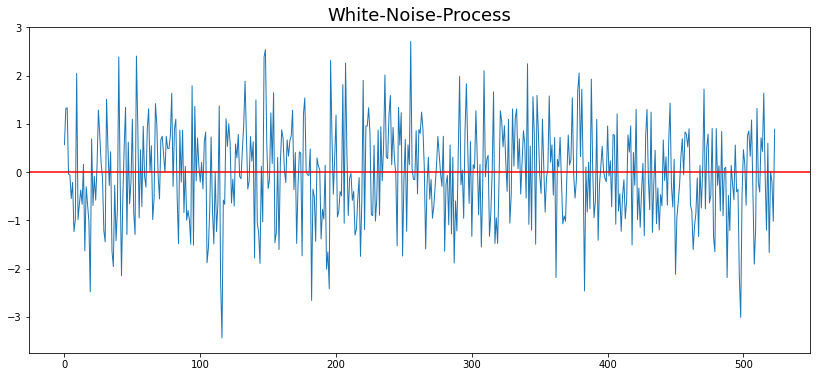

In [4]:
simulate_white_noise()

### Random Walk

*__What is a Random Walk?__*

In a random walk the next value in a sequence is a modification of the previous one. This connection between the different values forces them to have a dependence from one step to another and hence provides the series with a certain consistency and hence creates a much more realistic time series.

Simply put, imagine a drunk person in a narrow alley. The person can only go forward or backward. If we now follow the steps of the person in the alley and record them, this process is nothing other than a random walk. 

<br>

*__What is a Random Walk with Drift?__*

In a random walk model with drift, the model assumes that in each point in time the series takes a random step away from its last position with a nonzero mean step.
Let's take the example of the drunk person again. 
Now imagine that the right leg is shorter than the left. So the person will tend to take more steps to the right than to the left. The person therefore tends to move to the right on average and thus drifts.

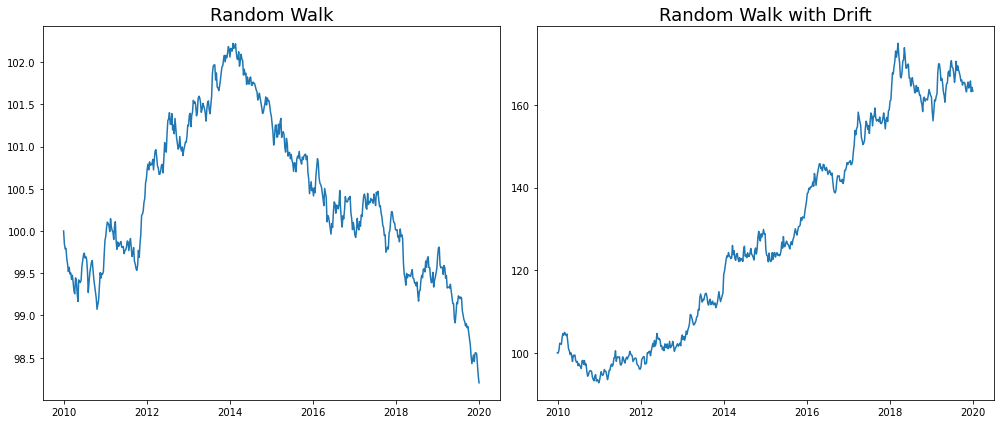

In [5]:
random_walks()

As you can see, the random walk goes randomly up and down and tends to follow the previous value and dosen't follow any particular pattern. In contrast, the random walk with drift has cleary a up trend. Thus, most following values tends to go up as down. 

### Stationarity and Non-Stationarity (Augmented Dickey Fuller Test)

*__What is a stationary process?__*

Stationarity in time series is a common assumption for forecasting techniques. A stationary process has, in general, specific properties:
- First, the time series's __mean does not change over time__ and should be constant at each time point. 
- Second, the __variance structure does__ also __not change over time__. 
- And the last one, the autocorrelation, meaning the __correlation between two different values__ from different time points, __are independent of the time span__. In other words, a stationary time series does not depend on time.

<br>

*__Why you should know that!__*

The assumptions mentioned above must be fulfilled so that the applied prediction models are able to detect real existing patterns within the time series and to transfer them mathematically correct into the future. If a time series is a non-stationary process, no reasonable predictions can be made about the future. 
That is, if the assumption of the __mean, variance__ and the __autocorrelation is violated__, the time series __is no longer stationary__ and results in not reliable models and no reliable predictions.

<br>

*__Okay, and where is now the connection between White Noise, Random Walk (Drift) and a non-stationary process?__*

The connection between white noise and a random walk with drift is similar to a regular time series prediction model and white noise (as briefly explained above) as such that white noise is integrated within a random walk.

Let's take our stocks as an example. The random walk can be observed as the daily level a stock (e.g. Apple) may have. White noise can be seen as the daily changes a stock may experience.

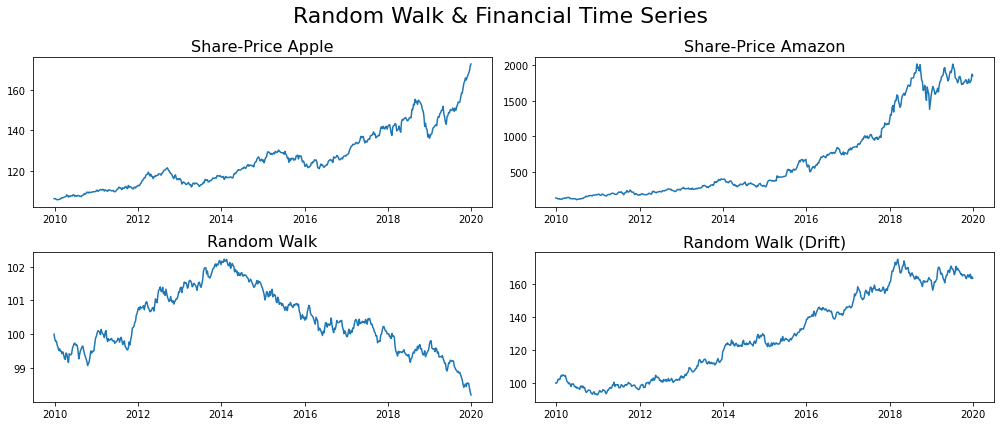

In [6]:
random_walks_and_finance()

If we compare the given time series with each other, we notice that the self-generated time series are very similar to the time series of 'Apple' or also 'Amazon'. Especially the random walk with drift could also have been generated on the financial market.

According to the definition, a random walk or random walk with drift is a non-stationary process and cannot be used for predictions as described above.

<br>

*__Okay, if the time series does look like a random walk then it is always a non-stationary process, right?__*

No, not exactly. 

It is just a first step to quanitfy the time series. You should always be able to justify your assumption. Therefore, we use a statistic test called the __Augmented Dicky Fuller Test__. Without further explaination how the ADF-Test works in detail, the underlying hypothesis is that:


> __Null hypothesis__: *Non Stationarity exists in the series.* 
 Vs. __Alternative Hypothesis__: *Stationarity exists in the series*

Fortunately, the Augmented Dickey Fuller Test is built into most statistical python packgages and can be applied directly to the time series.
As we know from our studies, we can reject the null hypothesis if the calculated p-value is below the significance level. Typically, the significance level is around 1%, 5% and 10%.


In [7]:
adf_explained(data)

The time series AAPL is non-stationary, because the p-value(0.996) is bigger than significance niveau 0.05.
The time series AMZN is non-stationary, because the p-value(0.9893) is bigger than significance niveau 0.05.
The time series Happy_AG is stationary, because the p-value(0.0366) is less than significance niveau 0.05.
The time series XY_AG is non-stationary, because the p-value(0.3095) is bigger than significance niveau 0.05.
The time series Random Walk is non-stationary, because the p-value(0.9624) is bigger than significance niveau 0.05.
The time series Random Walk (Drift) is non-stationary, because the p-value(0.9225) is bigger than significance niveau 0.05.


As we can see, the null hypothesis of the ADF test cannot be rejected in any of the time series shown. Thus, we are dealing with a total of four non-stationary processes and, as we already know, we cannot make any meaningful predictions based on the current data situation.

<br>

*__So what do we do now?__*

There are, of course, solutions to transform the respective time series resulting in stationary processes. However, we will deal with this in the second part of the tutorial.
For now let's have a look at the components of a time series.

## Components of a time series

>So far, we have taken a closer look at individual terms related to time series. However, we have always looked at the time series in its entirety. By definition, a time series consists of several components. Each component in itself thus represents certain partial information of the actual time series. This partial information (components) can be analysed more easily if they are considered separately from the basic time series. The components of a time series are typically differentiated into a systematic and an unsystematic (irregular) part. The systematic components are the trend, season and other explainable effects. The systematic component thus contains information about the basic time series. In contrast to this, is the so-called residual component. In this, as in classical regression, the non-explicable information is mapped.

In the next steps we will take a closer look at the individual components of a time series. This means in detail with the trend component, seasonal component and the unsystematic part, the residual component.

### Trend component (Analysis)

*__What does trend means?__*

Generally a trend is the linear increasing or decreasing behavior of the series over time. As long as the series is continously increasing or decreasing the analysis is quite simple. The partial information (component) thus refers to the general development of the time series over time. In simplified terms, the trend can only have three states. Either it is increasing, decreasing or constant over time. In the latter state, the time series has no trend component by definition.

The following figure illustrates the increasing trend over time with the increasing number of passengers at a US airport. A moving average is often used to illustrate the trend of a time series. This method has the advantage that punctual events are dampened and thus the trend of the time series clearly emerges. The rolling window in the following figure is 12 months. The number of passengers is thus illustrated in the moving average.

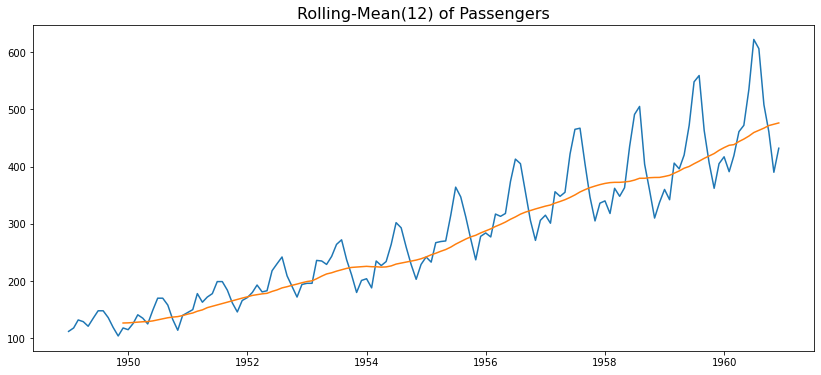

In [8]:
airline_trend()

### Seasonality component (Analysis)

*__What does seasonality means?__*

Seasonality is the repetition of data at a certain period of time interval. For instance in a stock we could potenitally observe an increase every year during christmas, when the company is selling more products. Generally we measure Seasonality by using autocorrelation, after the trend is substracted from the data.

From the graph below we see that every year there is an increase in passengers during the middle of the year (summer), hence suggesting, that there is a seasonal increase during holidays and vacation times. 

<br>

*__Is any cyclical pattern seasonal?__*

Not always. It is often necessary to distinguish between seasonality and cyclicality. Cyclical patterns occur when the data contains rises and falls, which are not fixed to a specific point in time (as opposed to Seasonality). These fluctuations often occur due to economic conditions, or are often related to the “business cycle.” In general, the average length of cycles is longer than the length of a seasonal pattern, and the magnitudes of cycles tend to be more variable than the magnitudes of seasonal patterns.


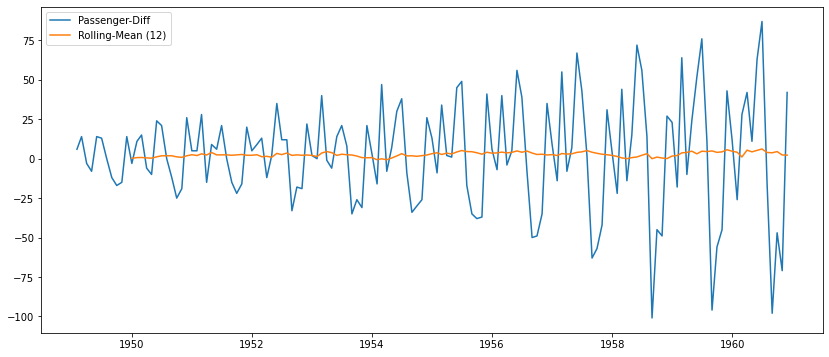

In [9]:
seasonal_cyclical()

### Irregular Patterns

*__What does irregulartiy means?__*

As already indicated, the residual component is non-explicable information within the time series. Thus, the residual component is often referred to as white noise.  Irregularity happens for a short duration and it’s non depleting. A very good example is the case of Ebola. During that period, there was a massive demand for hand sanitizers which happened erratically/systematically in a way no one could have predicted, hence one could not tell how much number of sales could have been made or tell the next time there’s going to be another outbreak.


In order to simplify the graphical analysis, the respective time series can be broken down directly into the essential components, as shown in the following figure.

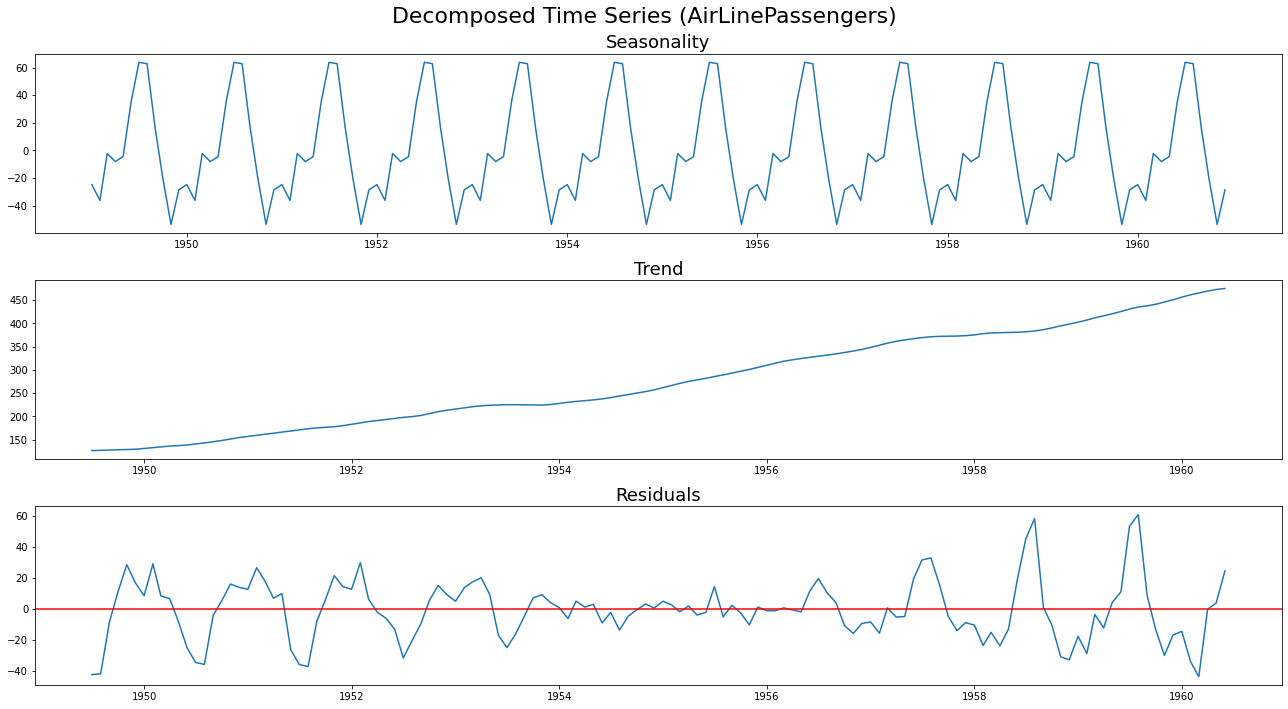

In [10]:
plot_decompose(airline=True)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Time Series Forecast

## Autoregressive Integrated Moving Average (AR(I)MA)

>Now let's move on to the second section of the tutorial. Here we will mainly deal with the so-called ARIMA (Autoregressive Integrated Moving Average) model. The ARIMA model actually consists of two main models, the AR (Autoregressive - Part) and the MA (Moving Average - Part). 
In the following, we will first look at the individual components and finally combine both parts. The resulting ARIMA model is one of the most common and simplest time series models and can be extended by further use of components such as explicit seasonality (SARIMA) or exogenous time components (SARIMAX). In this tutorial, however, we will focus on the simple ARIMA model.

### Autoregressive Models AR(p)

As we already know, a time series consists only of data points that were collected at certain points in time, in an even time span. By this definition, we only have the time series itself. In order to make predictions for the future, we use so-called historical data points. We therefore assume that the time series will follow its previous course (pattern) in the future. This approach is also called the autoregressive process. An AR(p) process maps the serial correlation of a point in time within the time series and updates it into the future. The parameter (p) determines the dependence on the past point in time. The simplest form of an autoregressive model is therefore when your observation at time t depends only on the observation at time t -1. Such a model is also described as a first-order autoregressive model or AR(1).

To quantify the correlation between time t and time t-1, the classical cross-sectional regression is used. The estimate of the coefficient in the autoregressive model is called phi.

The following blocks simulate an AR(1) process with different phi parameters to give you a feeling of how such a process can be represented.

In [11]:
np.random.seed(42)

# Simulate a AR(1)-Process with phi-parameter 0.5 and -0.9
AR1_05 = ArmaProcess(ar=np.array([1, 0.5]), ma=np.array([1]))
AR1_09 = ArmaProcess(ar=np.array([1, -0.9]), ma=np.array([1]))

In [12]:
np.random.seed(42)

# Generate sample data
sample_1 = AR1_05.generate_sample(nsample=523) * 0.1
sample_2 = AR1_09.generate_sample(nsample=523) * 0.1

# Assume that both sample data are financial time series
data['Sample_AG_AR(1)-Process'] = sample_1
data['Sample_GmbH_AR(1)-Process'] = sample_2

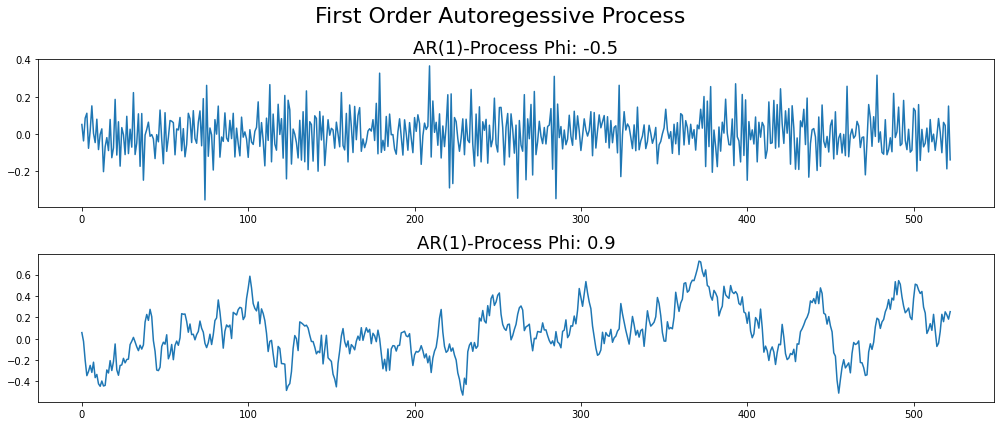

In [13]:
plot_process(sample_1, sample_2, ar=True)

As we can see, at least the AR(1) with phi -0.5 seems to follow a white-noise process. With phi 0.9, the autoregressive process tends to follow more of a random walk.

<br>


*__The question now is how we can estimate the individual coefficients and why it is actually a first-order autoregressive process.__*


To determine the parameter $p$, reference is often made to the so-called autocorrelation function or the partial autocorrelation function. 
As we already know, we need to estimate the parameter phi in order to fully describe an AR(p) process. In order to not include all lags in the cross-sectional regression, two functions are used. The AC-Function or PAC-Function helps to determine the serial or partial correlation at different points in time (lags), as we can see from the following figure. In this way, we can guess which parameter (p) is involved. 

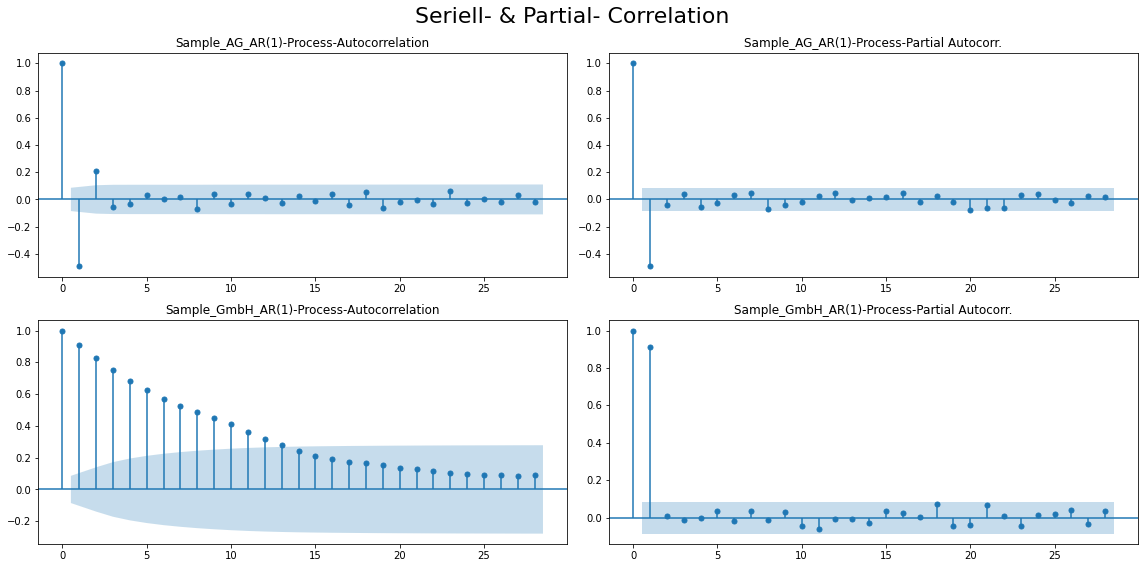

In [14]:
fig, ax = plt.subplots(2,2, figsize=(16, 8))
for axes, col in zip(ax, ['Sample_AG_AR(1)-Process', 'Sample_GmbH_AR(1)-Process']):
    plot_acf(data[col], ax=axes[0], title=col + '-Autocorrelation', alpha=0.05)
    plot_pacf(data[col], ax=axes[1], title=col + '-Partial Autocorr.', alpha=0.05)
    plt.suptitle('Seriell- & Partial- Correlation', fontsize=22)
    plt.tight_layout();

To determine the parameter p for an AR(p) process, mainly the partial autocorrelation is considered. It should be noted that a significant correlation can only be determined for lag 1 (column two). In other words, from the Partial Autocorrelation Graph we can see, that for every value larger than p (in this case larger than 2) the value goes to zero. Hence we obtain information on the order of p in an autoregressive process. Both artificially generated processes therefore really indicate a first-order autoregressive model.

<br>

*__And What is with the coefficient Phi?__*

Fortunately, the coefficient estimate can be determined easily and quickly using suitable Python functions.
The only information the function needs is the order of the autoregressive model. In our case, *p* is 1.

In [15]:
# Easy Forcast to see how the model works and what kind of realtionship do we have between the actual parameter and the estimation!
np.random.seed(42)

arma_mod_AG = ARMA(data['Sample_AG_AR(1)-Process'], order=(1, 0))
arma_mod_GmbH = ARMA(data['Sample_GmbH_AR(1)-Process'], order=(1,0))

result_arma_mod_AG = arma_mod_AG.fit()
result_arma_mod_GmbH = arma_mod_GmbH.fit()

In [16]:
# Show the result
print_coeffs_arma_model(model1=result_arma_mod_AG, model2=result_arma_mod_GmbH)

############################## Sample_AG_AR(1)-Process ##############################
Intercept (α) : -0.0
Coefficient (Φ) : -0.4933



############################## Sample_GmbH_AR(1)-Process ##############################
Intercept(α) : 0.0639
Coefficient (Φ) : 0.9086


Let's look at the coefficient estimates for the two AR(1) processes. We see that they are -0.4933 and 0.9086 respectively and very close to the true values -0.5 and 0.9.
Mathematically, our two processes can now be represented as:

<br>

$$ \text{AR(1):} \ x_t = \alpha + \phi x_{t-1} + \epsilon_t $$
<br>
$$ \text{Sample_AG_AR(1)-Process:} \ x_t =  0.00 - 0.4933 x_{t-1} $$
<br>
$$ \text{Sample_GmbH_AR(1)-Process:} \ x_t =  0.0639 + 0.9086 x_{t-1} $$

### Moving Average Models MA(q)

In contrast to an AR(p) process, an MA(q) process uses the information from the disturbance term $\epsilon$ in addition to past observations. Thus, an MA(q) process is able to use inexplicable information or observed errors from the past for future predictions. In a MA(q) model each value for Yt can be thought of as a weighted moving average of the past few forecast errors. Also do not confuse MA(q) models with MA(q) smoothing. A moving average model is used for forecasting future values, while moving average smoothing is used for estimating the trend-cycle of past values.

In the following blocks we will approach the MA(q) process in the same way as we did for the Ar(p) process. That is, first we will again simulate two processes ($\theta = -0.5$ and $\theta = 0.9$). The procedure for estimating the coefficient *Theta* is the same as for the coefficient *Phi* in AR(p). The order of the parameter *q* can again be determined via the autocorrelation function or the partial autocorrelation function.


In [17]:
np.random.seed(42)

# Generate a MA(1)-Process
MA1_05 = ArmaProcess(ar=np.array([1]), ma=np.array([1, 0.5]))
MA1_09 = ArmaProcess(ar=np.array([1]), ma=np.array([1, -0.9]))

In [18]:
np.random.seed(42)

# Generate sample data
sample_1 = MA1_05.generate_sample(nsample=523) * 0.1
sample_2 = MA1_09.generate_sample(nsample=523) * 0.1

# Assume that both sample data are financial time series
data['Sample_AG_MA(1)-Process'] = sample_1
data['Sample_GmbH_MA(1)-Process'] = sample_2

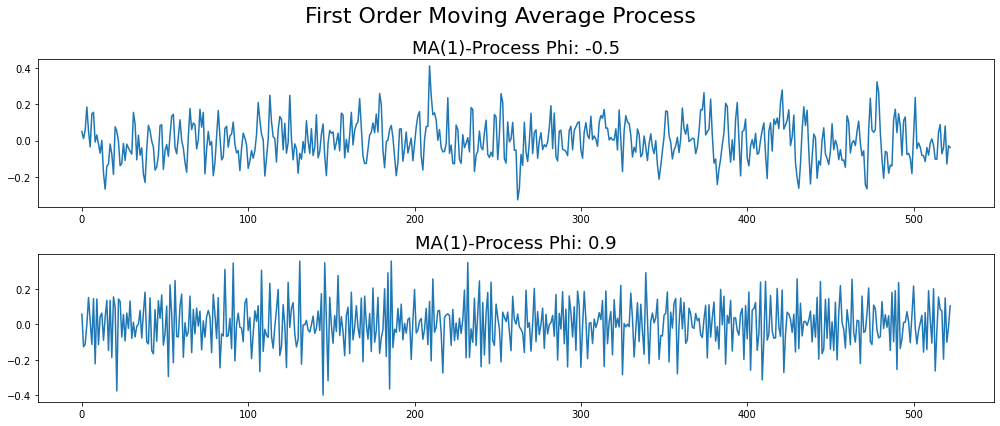

In [19]:
plot_process(sample_1, sample_2, ma=True)

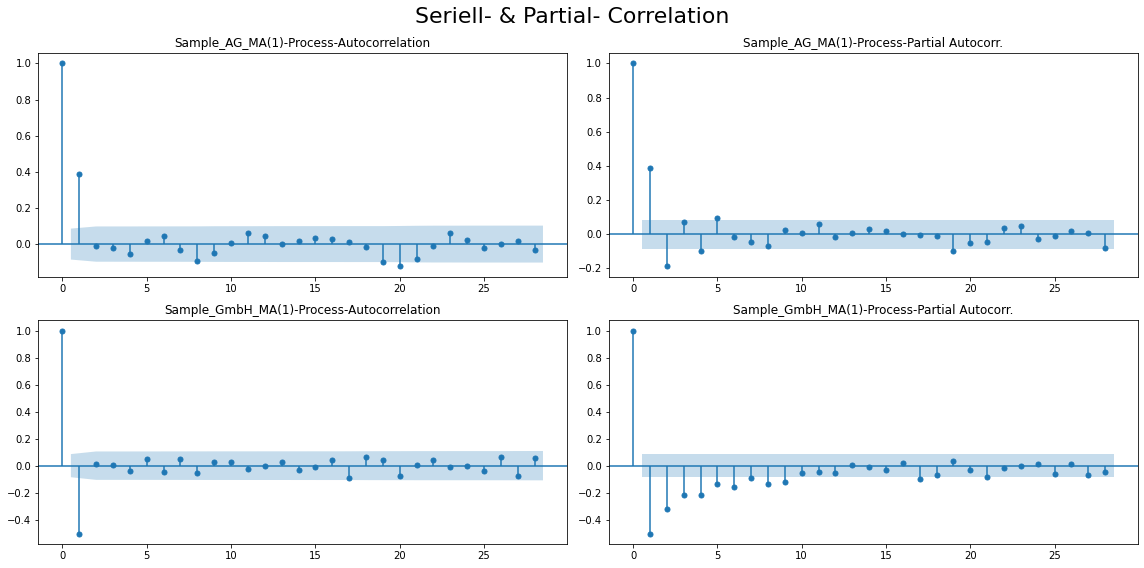

In [20]:
fig, ax = plt.subplots(2,2, figsize=(16, 8))
for axes, col in zip(ax, ['Sample_AG_MA(1)-Process', 'Sample_GmbH_MA(1)-Process']):
   plot_acf(data[col], ax=axes[0], title=col + '-Autocorrelation')
   plot_pacf(data[col], ax=axes[1], title=col + '-Partial Autocorr.')
   plt.suptitle('Seriell- & Partial- Correlation', fontsize=22)
   plt.tight_layout();

Let's take a closer look at the Kollelograms of the respective processes. The AC function of both processes points to a correlation with lag-1 in both processes, so it is more likely to be an MA(q) process. Which order the parameter *q* assumes can again be identified via the last clearly significant lag parameter. In our case, $p = 1$.

Just as for AR(p) processes, we could also guess the respective parameters for MA(q) processes. Since we now know that it is probably an MA(1) process, we can estimate the coefficient $\theta$.

In [21]:
# Easy Forcast to see how the model works and what kind of realtionship do we have!
np.random.seed(42)

arma_mod_AG = ARMA(data['Sample_AG_MA(1)-Process'], order=(0, 1))
arma_mod_GmbH = ARMA(data['Sample_GmbH_MA(1)-Process'], order=(0, 1))

result_arma_mod_AG = arma_mod_AG.fit()
result_arma_mod_GmbH = arma_mod_GmbH.fit()

In [22]:
# Show the result
print_coeffs_arma_model(model1=result_arma_mod_AG, model2=result_arma_mod_GmbH)

############################## Sample_AG_AR(1)-Process ##############################
Intercept (α) : 0.0
Coefficient (Φ) : 0.5059



############################## Sample_GmbH_AR(1)-Process ##############################
Intercept(α) : 0.0008
Coefficient (Φ) : -0.8998



$$ \text{MA(1):} \ x_t = \mu + \epsilon_{t} + \theta \epsilon_{t-1}  $$ 

<br>

$$ \text{Sample_AG_MA(1)-Process:}  \ x_t = 0.00 + \epsilon_{t} - 0.5059 \ \epsilon_{t-1} $$

<br>

$$ \text{Sample_GmbH_MA(1)-Process:}  \ x_t = 0.0008 + \epsilon_{t} - 0.8998 \ \epsilon_{t-1} $$

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Forecasting with ARIMA

So far, we have considered both processes (AR(p) & MA(q)) separately. Since an AR(p) process refers only to past observations and an MA(q) process refers more to the past observed error (as explained above), both processes are often used in conjunction with each other. This results in a so-called ARMA(p, q) model. 
The prerequisite for modelling AR and MA processes is that your time series is stationary. This means that your time series has the same mean and the same variance at all times; trends and different seasonal effects are not (any longer) present in stationary time series, as we already explained in section one. In reality, however, many time series are not uniform but follow trends or seasonalities that show different means and variances over time. For example, the variance in a company's sales is usually not regular and follows a certain trend. To correctly determine non-stationary or non-uniform time series, you need to make them stationary. This is made possible by ARIMA models - Autoregressive Integrated Moving Average models. In ARIMA processes, trends in time series are integrated via differentiation and thus become stationary. This means that the mean value of your observations becomes constant by subtracting your outcome, e.g. your sales y at time t-k, from y at time t. It can also be the case that the variance of your sales y at time t is constant. It may also be that the variance of your observations is non-stationary so that y can be transformed to stationary using the natural logarithm. Likewise, other natural transformations of the time series are possible to ensure stationary time series.

<br>

In the following, we will look at sales data of Demand AG from 01.01.2013 to 31.12.2013. The aim is to predict the sales 
in the first week of January 2014.

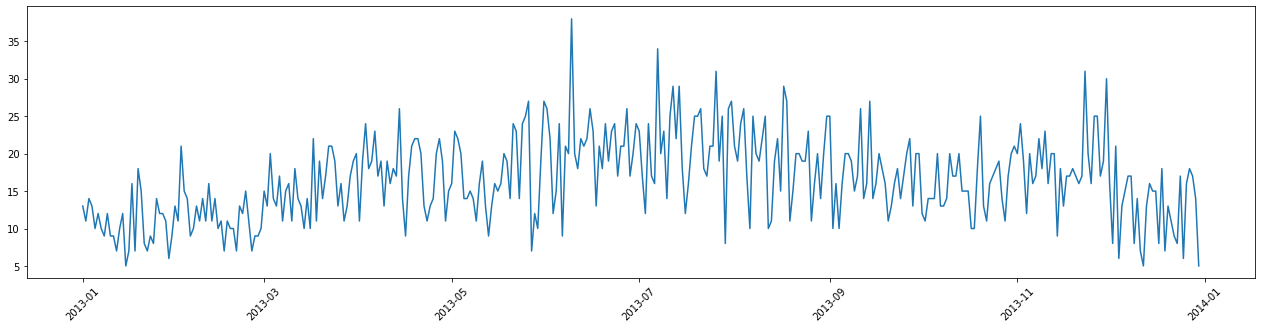

In [23]:
demand = plot_demands()

At first glance, the sales figures do not show any significant conspicuity in trend or seasonality. We can see a slight upward trend in sales towards the middle of the year, followed by a downward trend towards the end of the year.
As we already know, to obtain meaningful predictions, the time series must be stationary. The graphical analysis suggests that this is a non-stationary time series. Indicators such as the possible trend speak against a stationary process in this case.
To quantify the graphical analysis, we use the Augmented Dickey Fuller Test.

In [24]:
adf_explained(demand)

The time series sales is non-stationary, because the p-value(0.2874) is bigger than significance niveau 0.05.
The time series month is non-stationary, because the p-value(0.8949) is bigger than significance niveau 0.05.


The Dickey Fuller confirms our graphical analysis by showing that the null hypothesis cannot be rejected and that it is, therefore, a non-stationary process.

<br>

As an additional confirmation and to identify trends and seasonalities, we split our time series into its components.

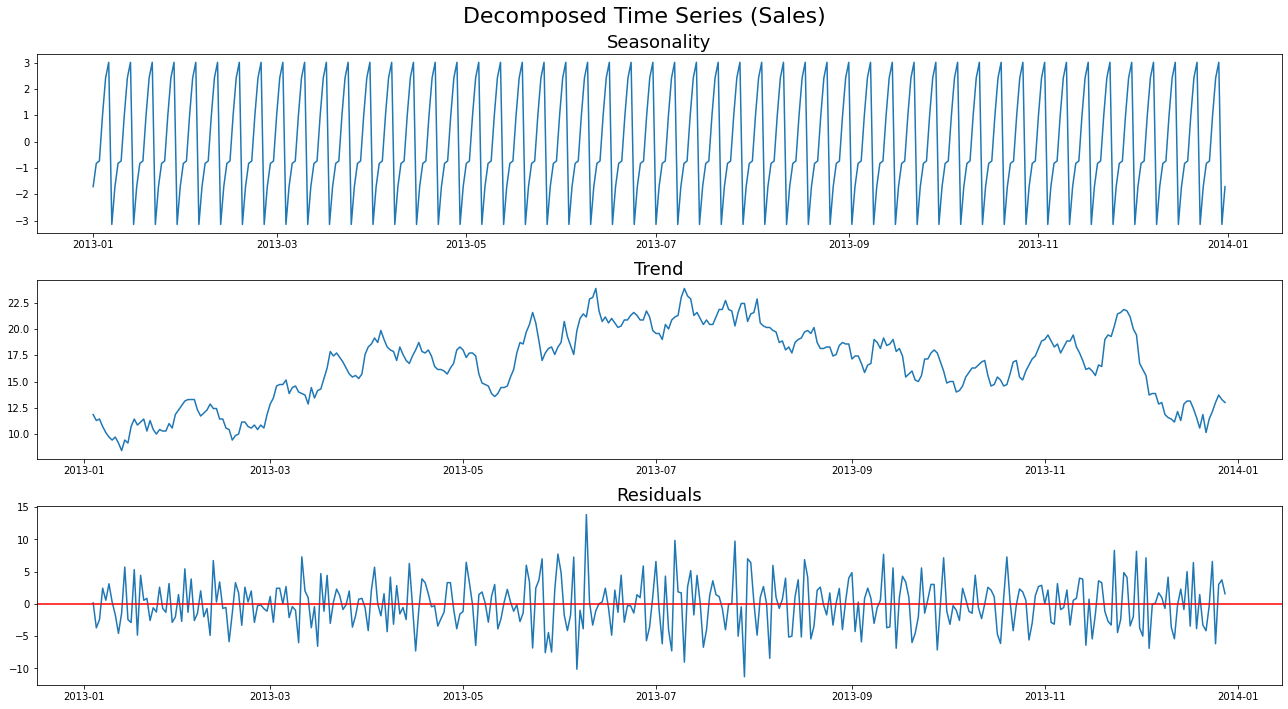

In [25]:
plot_decompose(demands=True)

From the figure above, it is now clear that we have a distinct seasonality in the data. The trend analysis confirms the previous assumption.

We now know that it is a non-stationary process with a slight trend and clear seasonality. The parameters (p,d,q) have to be determined to transfer these properties into the prediction model.
To do this, we look at the correlograms of the non-stationary process and the first differentiation of the sales values in the following figure.

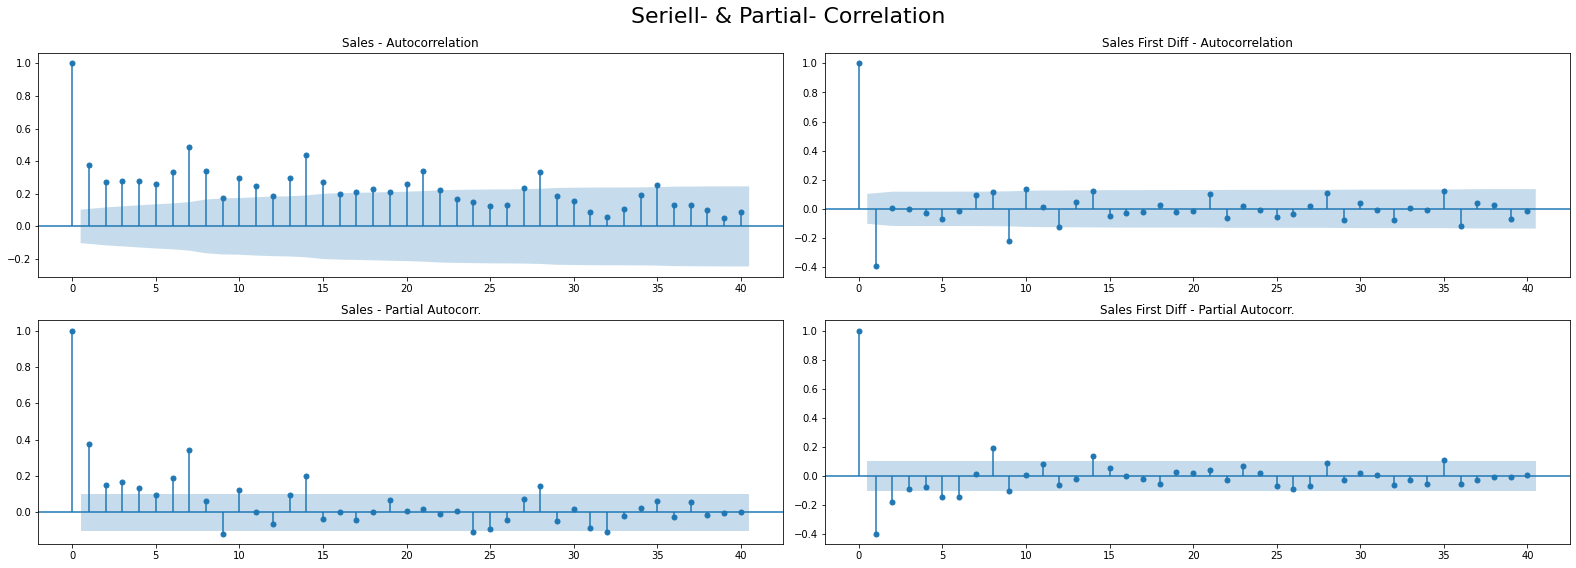

In [26]:
first_diff = demand.sales.pct_change().dropna()
fig, ax = plt.subplots(2, 2, figsize=(22, 8))
plot_acf(demand.sales, ax=ax[0, 0], title='Sales - Autocorrelation', lags=40, alpha=0.05)
plot_pacf(demand.sales, ax=ax[1, 0], title='Sales - Partial Autocorr.', lags=40, alpha=0.05)
plot_acf(first_diff, ax=ax[0, 1], title='Sales First Diff - Autocorrelation', lags=40, alpha=0.05)
plot_pacf(first_diff, ax=ax[1, 1], title='Sales First Diff - Partial Autocorr.', lags=40, alpha=0.05)
plt.suptitle('Seriell- & Partial- Correlation', fontsize=22)
plt.tight_layout();

Let's focus on "Sales First Diff" and look at both correlation functions. If we look at the autocorrelation function, we can see that after Lag-1, most of the correlation coefficients are insignificant. Accordingly, we can assume an MA(q = 1) process here. In the partial correlation function illustration, we can read that it is possibly an AR(p=2) or AR(p=8) process. Since both analyses took place on the first differentiation, the parameter d is 1.

<br>

In the next chucks we define the model (SAMRIMAX) with the parameters mentioned before. The endogenous variable in our case is the time series "Sales". The attribute "order" must be filled with the respective parameters "order=(p=2, d=1, q=1)". 

In [29]:
# Fit the model
arima_model_2 = sm.tsa.statespace.SARIMAX(endog=demand.sales, order=(2,1,1), trend='n').fit(disp=False)
arima_model_8 = sm.tsa.statespace.SARIMAX(endog=demand.sales, order=(8,1,1), trend='n').fit(disp=False)

To evaluate the model, i.e. to know how well or poorly our model can describe the time series, we make so-called in-sample predictions.

In [30]:
# Predict Sales (In-Sample)
demand['In-Sample-Prediction_model_2'] = arima_model_2.predict(start = demand.index[0], end=demand.index[-1])
demand['In-Sample-Prediction_model_8'] = arima_model_8.predict(start = demand.index[0], end=demand.index[-1])

In [31]:
demand.head()

,sales,month,In-Sample-Prediction_model_2,In-Sample-Prediction_model_8
date,,,,
2013-01-01,13,1,0.000000,0.000000
2013-01-02,11,1,12.999792,12.999791
2013-01-03,14,1,11.831809,11.835366
2013-01-04,13,1,13.016360,12.983896
2013-01-05,10,1,12.677975,12.753216


The predictions generated can be seen in the table above for the first days of the time series. In order to quantify the prediction quality, i.e. the quality of the model, various metrics are typically determined. 
The following values result for the two models.

In [32]:
# Evaluate in Sample
print(f'In Sample Evaluation fot Model 2:')
show_metrics(demand['sales'], demand['In-Sample-Prediction_model_2'])
print('\n')
print(f'In Sample Evaluation fot Model 8:')
show_metrics(demand['sales'], demand['In-Sample-Prediction_model_8'])

In Sample Evaluation fot Model 2:
MAPE:	26.8146 %
MSE.	22.9512
RMSE:	4.7907


In Sample Evaluation fot Model 8:
MAPE:	25.3427 %
MSE.	21.122
RMSE:	4.5959


It seems that we were quite right with our choice of parameters.  The mean absolute percentage error (MAPE) of 26.81% for Model 2 and a MAPE of 25.34% for Model 8.
A direct comparison shows that the parameter selection for Model 8 applies better to use Model 8 for the so-called out-of-sample forecast.

In [35]:
# Choose Model 8 to Forecast Sales-values for the next week (7-days)
forecast_range = pd.date_range(start='1/1/2014', end='1/7/2014', freq='D')
forecast_steps = len(forecast_range) + 1 # (7-days)

# Forecast Sales (Out-of-Sample)
sales_forecast = arima_model_8.forecast(steps=forecast_steps)
sales_forecast = pd.DataFrame(sales_forecast).rename(columns={'predicted_mean': 'Sales-Forecast'})
sales_forecast

,Sales-Forecast
2013-12-31,12.709067
2014-01-01,11.289668
2014-01-02,13.581271
2014-01-03,14.776789
2014-01-04,14.764664
2014-01-05,13.152079
2014-01-06,10.805482
2014-01-07,12.344482


The following figure illustrates the course of the time series itself and the "in-sample prediction", and the final forecast for the sales values. 
It is noticeable that the model cannot correctly reproduce the sometimes strong outliers. In this case, the model lacks information about the seasonal component. 
However, this will not be discussed in this tutorial.

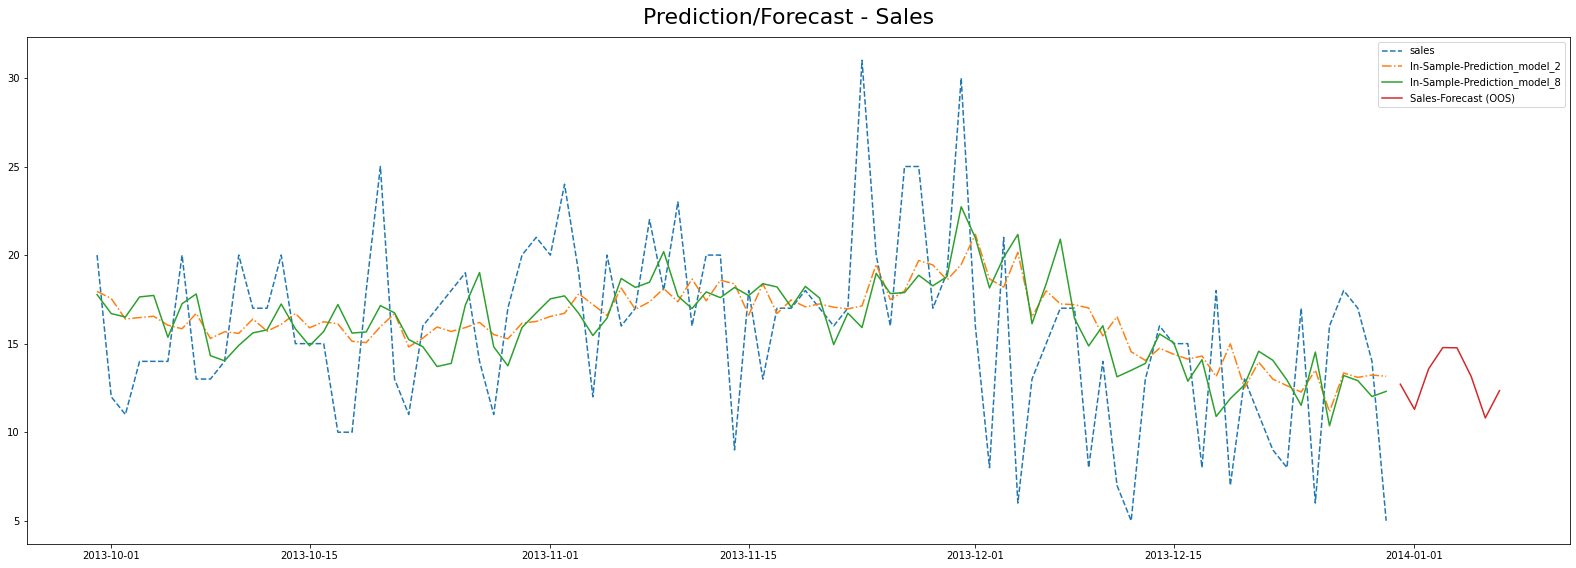

In [49]:
# Visualize forecasts
start_date = '2013-09-30'
end_date = '2013-12-31'

fig, ax = plt.subplots(1,1 ,figsize=(22, 8))

ax.plot(demand['sales'][start_date:end_date], linestyle='dashed')
ax.plot(demand['In-Sample-Prediction_model_2'][start_date:end_date], linestyle='dashdot')
ax.plot(demand['In-Sample-Prediction_model_8'][start_date:end_date])
ax.plot(sales_forecast)
ax.legend(['sales', 'In-Sample-Prediction_model_2', 'In-Sample-Prediction_model_8', 'Sales-Forecast (OOS)'])
plt.suptitle('Prediction/Forecast - Sales', fontsize=22)
plt.tight_layout();

## Summary

The tutorial should have taught you some fundamental concepts such as white noise, random walk and stationarity in the context of time series analysis. Also, you should now be able to apply and understand the first fundamental time series models such as an ARIMA-Model. 